# Image recognition of vehicle's make (and model) using TensorFlow

**Credits**: This code was produced by [Natacha Chenevoy](https://github.com/mednche) and is available on [Github](https://github.com/mednche/Vehicle-Image-Recognition). I ([Nick Malleson](http://nickmalleson.co.uk/)) have adapted it slightly here, but have made only relatively minor changes so can't take any of the credit. For full details about the original project, the data, etc., refer to Natacha's page.

## Introduction

This script trains a convolutional neural network model to recognise a vehicle's make and model. This was done using Google's [Tensorflow](https://www.tensorflow.org/) and [TFlearn](http://tflearn.org/), a deep learning library built on top of Tensorflow. 

## Dataset

The dataset, which is available as part of a machine learning competition on [Kaggle](https://www.kaggle.com/c/carvana-image-masking-challenge/data) contains a large number of photographs of cars. There is also a separate file that tells us the make and model of each car. The challenge is to create an algorithm that will automatically work out the make and model from new images. 

**IMPORTANT**: Together, the pictures files are very big. Therefore you have to _**download the images yourself**_ before the code below will work:

 1. [This page](https://www.kaggle.com/c/carvana-image-masking-challenge/data) lists all of the data files that are available for the competition. You need to download `train.zip`, extract the images, and store them in the `CarImages` folder
 2. If you want more images (which will make the model take longer to train, but might lead to better results) then also download `test.zip`. Again, extract those images and put them in the `CarImages` folder.

## Training the network

I have trained two models with the same architecture (see below). 
- Model 1 takes make, model and vehicle ID in input
- Model 2 only takes make and model in input


**Architecture of the neural network:**

Input -> Conv -> Relu -> Pool -> Conv -> Relu -> Pool -> FullyConnected -> Regression

This architecture is rather commonly used in deep learning.

**Neural network terminology:**
- *One epoch* = one forward pass and one backward pass of all the training images
- *Batch size* = the number of training images in one forward/backward pass. The higher the batch size, the more memory space needed, but it will be faster.
- *Number of iterations* = number of passes, each pass using [batch size] number of images. 
To be clear, one pass = one forward pass + one backward pass (the forward pass and backward pass are not counted as two different passes).



## Import necessary libraries

We are going to use a library called [Tensor Flow](https://www.tensorflow.org/). This is an "an open source software library for numerical computation using data flow graphs". It is commonly used to do image recognition tasks (among other things).

You need to install the following libraries:
 - `conda install tensorflow scikit-learn pillow imageio`
 - `pip install tflearn`
 
 
You also need `pandas` and `numpy` but may have these already as we installed them in the previous tutorial. Just in case not, you can install them both by installing `scipy`:
 - `conda install scipy`

In [1]:
import os
import pandas as pd
from os.path import splitext
import numpy as np
import random

# tensorflow
import tensorflow as tf

# tflearn and some helpers
import tflearn
from tflearn.data_utils import shuffle
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

# for reading images
import imageio
from PIL import Image

# Displaying things (graphs etc) 
import matplotlib.pyplot as plt



hdf5 is not supported on this machine (please install/reinstall h5py for optimal experience)
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


## Data Preparation

### Get name of all images in folder

Open the folder with the images and get the name of every image.

In [2]:
# Get all files in merged folder
folder = "./CarImages"
onlyfiles = []
for f in os.listdir(folder):
    if os.path.isfile(os.path.join(folder, f)) and \
      os.path.join(folder, f)[-4:] == ".jpg":
        onlyfiles.append(f)
print("Working with",len(onlyfiles),"images")

# due to low memory available, I restricted the dataset size
#onlyfiles = onlyfiles[:5000]
#print("Reduced to {0} images".format(len(onlyfiles)))


Working with 5088 images


### Fetch the labels associated with each images

There is a file called `metadata.csv` that stores the make and model of each car. The code below reads this file and cross-references it with the name of the image file to work out which car is in each image.

In [3]:
train_files = []
y_train =  pd.DataFrame()

# import the metadata for the cars
data =  pd.read_csv("./CarImages/metadata.csv")

for _file in onlyfiles:
    # add file name to list of train_file
    train_files.append(_file)
    
    # remove name extension 
    file = splitext(_file)[0]
    
    # get id of vehicle
    car_id = file.split("_")[0]
    
    # get corresponding make
    make = data[data.id == car_id].make.tolist()[0]
    model = data[data.id == car_id].model.tolist()[0]
    name = car_id
    
    y_train = y_train.append({'name': name, 'make':make, 'model':model}, ignore_index=True)
    
print("Files in train_files: {}".format(len(train_files)))

Files in train_files: 5088


### Check the data

Lets have a look to see which cars we actually have in the data (just first and last few)

In [4]:
y_train

,make,model,name
0,Acura,RLX,00087a6bd4dc
1,Acura,RLX,00087a6bd4dc
2,Acura,RLX,00087a6bd4dc
3,Acura,RLX,00087a6bd4dc
4,Acura,RLX,00087a6bd4dc
5,Acura,RLX,00087a6bd4dc
6,Acura,RLX,00087a6bd4dc
7,Acura,RLX,00087a6bd4dc
8,Acura,RLX,00087a6bd4dc
9,Acura,RLX,00087a6bd4dc


Check all vehicles have 16 images each (from different angles)

In [5]:
# number of images per vehicle
df = y_train.groupby(y_train.name).count()
df[df.make != 16]

,make,model
name,,


Good, the table above is empty which means that all cars have a label attached in "metadata.csv"

Check that all images have a label in 'metadata.csv'

In [6]:
# number of images and vehicles
print("The dataset has got {} images of {} unique vehicles".format(len(onlyfiles), len(y_train.name.unique())))

The dataset has got 5088 images of 318 unique vehicles


An example of a randomly chosen image and its labels:

In [7]:
image_num = random.randint(0,len(onlyfiles)-1)
image = imageio.imread(os.path.join(folder, onlyfiles[image_num]))
print(plt.imshow(image, cmap=plt.cm.gray))

# ...And corresponding labels (make and model)
y_train.iloc[image_num]

AxesImage(54,36;334.8x217.44)


make              Kia
model           Rondo
name     c7145a80089e
Name: 3929, dtype: object

### Crop the images

To make things easier on the computer, we will reduce the resolution of the images.

In [8]:
# Open the first image (all images have the same size)
im = Image.open(os.path.join(folder, train_files[0]))

# set size here
size = 450, 450 
#size = [x/3.0 for x in im.size] # Make the images one third of their original size
print("Downscaling from {} to {}".format(im.size, size))

# resize
im.thumbnail(size,Image.ANTIALIAS)

# crop
img = im.crop((0, 50, im.size[0], im.size[1]))

# show cropped image
plt.imshow(img, cmap=plt.cm.gray)

# get final dimentions of all images
image_width, image_height = img.size

# set number of colour channels 
channels = 3

Downscaling from (1918, 1280) to (450, 450)


### Add all images to an array

Creat a large array that will store all of the (cropped) images, ready for analysis. This might take a few minutes

In [9]:
# (for training on coloured images)
dataset = np.ndarray(shape=(len(train_files), image_height, image_width, channels), dtype=np.float32)

i = 0
for _file in train_files:
    img = Image.open(os.path.join(folder,_file))
    # resize
    img.thumbnail(size,Image.ANTIALIAS)
    # crop top of image to reduce size             
    img = img.crop((0, 50, im.size[0], im.size[1]))
    
    # Convert to Numpy Array
    x = np.array(img)  
   
    # Normalize
    dataset[i] = x
    i += 1
    if i % 500 == 0:
        print("Have added {} images to array".format(i))
print("All images to array!")

#dataset[0]

Have added 500 images to array
Have added 1000 images to array
Have added 1500 images to array
Have added 2000 images to array
Have added 2500 images to array
Have added 3000 images to array
Have added 3500 images to array
Have added 4000 images to array
Have added 4500 images to array
Have added 5000 images to array
All images to array!


### Recode car labels (make, model, id) into numbers instead of strings

This makes it easier for the computer to understand them - it is easier for computers to distinguish between numbers than it is between sequences of characters (which are also just nubers, but big and complicated ones!).

In [10]:
# Associate each unique make with a number
maketonumberdict = {}
unique_make = y_train.make.unique() 
for i in range(len(unique_make)):
    maketonumberdict[unique_make[i]] = i 

# Associate each unique model with a number                  
modeltonumberdict = {}
unique_model = y_train.model.unique() 
for i in range(len(unique_model)):
    modeltonumberdict[unique_model[i]] = i

# Associate each unique id string with a number                  
idtonumberdict = {}
unique_id = y_train.name.unique() 
for i in range(len(unique_id)):
    idtonumberdict[unique_id[i]] = i

    
def makeAndModelToNumber(mydata, makedict, modeldict, iddict):
    mydata_copy = mydata.copy() # make a copy otherwise the changes are made in both df
    for i in range(len(mydata_copy['make'])):
        mydata_copy.loc[i,'make'] = makedict[mydata_copy.loc[i,'make']]
        mydata_copy.loc[i,'model'] = modeldict[mydata_copy.loc[i,'model']]
        #mydata_copy.loc[i,'name'] = iddict[mydata_copy.loc[i,'name']]
    return mydata_copy

clean_y_train = makeAndModelToNumber(y_train, maketonumberdict, modeltonumberdict, idtonumberdict)

# Drop the 'name' field as we don't care about this
# (it's a unique name for each make-model combination)
clean_y_train = clean_y_train.drop("name", axis = 1)
clean_y_train.head(20)

,make,model
0,0,0
1,0,0
2,0,0
3,0,0
4,0,0
5,0,0
6,0,0
7,0,0
8,0,0
9,0,0


## Training the model

**This is the main part of the program**. In the code below, the data are divided into 'test' and 'training' sets (recall that machine learning algorithms are usually trained on one set of data, but hten tested on another set). The Tensor Flow pipline is then created as there are a number of different operations that are applied to the images (discussing all of the elements in detail would could be a whole university module on its own!).

This can take around 30 mins with 5000.

Begin by resetting tensorflow graph data

In [11]:
# reset underlying graph data
tf.reset_default_graph()
tf.get_default_graph().get_operations()

[]

Now prepare the model

In [12]:
#with tf.Graph().as_default():
with tf.Session() as session:
    
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(dataset, clean_y_train, test_size=0.2, random_state=33)
    
    # trainx and trainy should be numpy arrays
    y_train = np.array(y_train)
    y_test = np.array(y_test)
    
    # Make sure the data is normalized
    img_prep = ImagePreprocessing()
    img_prep.add_featurewise_zero_center()
    img_prep.add_featurewise_stdnorm()


    ### Define our network architecture:
    
    # Input is a tensor: height*width images with 3 color channels (red, green and blue) 
    
    network = input_data(shape=[None, image_height, image_width, channels],
                         data_preprocessing=img_prep)
    
    # Step 1: Convolution
    # NB: low level recognises edges and curves, high level recognises wheel shapes and logos
    network = conv_2d(network, 5, 7, activation='relu') # number of filters: 5, filter size 7 
    
    # Step 2: Max pooling
    network = max_pool_2d(network, 2) # kernel size
    
    # Step 3
    network = conv_2d(network, 5, 3, activation='relu') # number of filters: 5, filter size 3 
    
    # Step 4: Max pooling
    network = max_pool_2d(network, 2) # kernel size
                        
    # Step 5: Fully-connected 2 node neural network
    # Looks at all images for each class and identify the high level features in common
    network = fully_connected(network, 2, activation='relu') # number of outputs = number of classes the model has to choose from
    
    # Step 6: Regression
    network = tflearn.regression(network)
                             
    
    # Wrap the network in a model object
    model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir ="./tmp/tflearn_logs")
    

At this point, the tensor flow model has been created, but hasn't done anything yet.

**Now pass the images through the model pipeline it to train it**. This is the part that can take some time. See if you can hear the computer fan start to speed up; it has a lot of work to do.

In [13]:
with session:
    # Train the model
    %time model.fit(X_train, y_train, validation_set= (X_test, y_test), show_metric=True, batch_size=10)
    
    # Save model when training is complete to a file
    model.save("carclassifier.tfl")
    
    print("Network trained and saved as carclassifier.tfl!")
    
    score = model.evaluate(X_test, y_test, batch_size=10)
    # accuracy: 0.99899999976158138
    # loss: 210.93408
    
    print("Accuracy of the model: {}".format(score))

---------------------------------
Run id: MH1E25
Log directory: ./tmp/tflearn_logs/
---------------------------------
Preprocessing... Calculating mean over all dataset (this may take long)...
Mean: 164.738 (To avoid repetitive computation, add it to argument 'mean' of `add_featurewise_zero_center`)
---------------------------------
Preprocessing... Calculating std over all dataset (this may take long)...
STD: 61.551 (To avoid repetitive computation, add it to argument 'std' of `add_featurewise_stdnorm`)
INFO:tensorflow:Summary name Accuracy/ (raw) is illegal; using Accuracy/__raw_ instead.
---------------------------------
Training samples: 4070
Validation samples: 1018
--


InvalidArgumentError: Nan in summary histogram for: Conv2D_1/W/Gradients
	 [[Node: Conv2D_1/W/Gradients = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Conv2D_1/W/Gradients/tag, Adam/clip_by_global_norm/Adam/clip_by_global_norm/_2)]]

Caused by op 'Conv2D_1/W/Gradients', defined at:
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\zmq\eventloop\ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tornado\ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\zmq\eventloop\zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\zmq\eventloop\zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\zmq\eventloop\zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tornado\stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\IPython\core\interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\IPython\core\interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\IPython\core\interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-12-0d5a18b3cfb9>", line 46, in <module>
    model = tflearn.DNN(network, tensorboard_verbose=3, tensorboard_dir ="./tmp/tflearn_logs")
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\models\dnn.py", line 65, in __init__
    best_val_accuracy=best_val_accuracy)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\helpers\trainer.py", line 131, in __init__
    clip_gradients)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\helpers\trainer.py", line 710, in initialize_training_ops
    self.create_summaries(tensorboard_verbose)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\helpers\trainer.py", line 921, in create_summaries
    summarize_gradients(self.grad, summ_collection)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\helpers\summarizer.py", line 75, in summarize_gradients
    summaries.add_gradients_summary(grads, "", "", summary_collection)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\summaries.py", line 132, in add_gradients_summary
    collection_key))
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tflearn\summaries.py", line 44, in get_summary
    summ = tf.summary.histogram(tag, value)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tensorflow\python\summary\summary.py", line 221, in histogram
    tag=scope.rstrip('/'), values=values, name=scope)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tensorflow\python\ops\gen_logging_ops.py", line 131, in _histogram_summary
    name=name)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tensorflow\python\framework\ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "C:\Users\geonsm\AppData\Local\conda\conda\envs\PRP\lib\site-packages\tensorflow\python\framework\ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Nan in summary histogram for: Conv2D_1/W/Gradients
	 [[Node: Conv2D_1/W/Gradients = HistogramSummary[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"](Conv2D_1/W/Gradients/tag, Adam/clip_by_global_norm/Adam/clip_by_global_norm/_2)]]


INFO:tensorflow:C:\Users\geonsm\Downloads\machine-learning\machine-learning\practicals\vehicle-image-recognition\carclassifier.tfl is not in all_model_checkpoint_paths. Manually adding it.
Network trained and saved as carclassifier.tfl!
Accuracy of the model: [0.049115914273238602]


It looks like the model has not performed very well, which was to be predicted considering we only provided 5000 images.

### Test on a single image

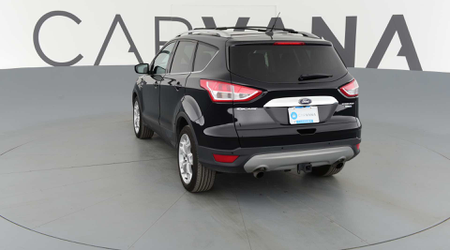

In [14]:
# choose a number between 0 and 1000 (size of the test set)
i = random.randint(0,999)
# revert type to uint8 to see image
Image.fromarray(X_test[i].astype(np.uint8), 'RGB') 

In [15]:
# A copy is made here in case something goes wrong and we lose X_test.
X_test_copy = X_test.copy()

# revert the dictionnary for fast query
numbertomakedict = {v: k for k, v in maketonumberdict.items()}
numbertomodeldict = {v: k for k, v in modeltonumberdict.items()}

# Model prediciton
y_pred = model.predict_label(X_test_copy[i:i+1])
print("Make: {}".format(numbertomakedict[y_pred[0][0]]))
print("Model: {}".format(numbertomodeldict[y_pred[0][1]]))

# Actual answer
print("The actual answer is: {} {}".format(numbertomakedict[y_test[i][0]], numbertomodeldict[y_test[i][1]]))

Make: Nissan
Model: RLX
The actual answer is: Ford Escape


### Evaluate performance of model for car make

We could do with more powerful computers to test all of the images. Just do 75.

In [16]:
# make a prediction for the first 75 vehicles
y_pred = model.predict_label(X_test_copy[:75])
#y_pred = model.predict_label(X_test_copy)

In [17]:
# get only the make
make_true = [i[0] for i in y_test[:75]]
make_pred = [i[0] for i in y_pred]

In [18]:
# Confusion matrix
confusion_matrix(make_true, make_pred)

array([[0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 6, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 7, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 4, 0, 0, 0, 0,

In [19]:
# Precision (total ratio of tp/(tp + fp))
precision_score(make_true, make_pred, average='micro')

0.0

In [20]:
# Recall
recall_score(make_true, make_pred, average='micro')

0.0

In [21]:
# F1 score
f1_score(make_true, make_pred, average='micro')

0.0

In [22]:
# Cohen's kappa
cohen_kappa_score(make_true, make_pred)

0.0